<a href="https://colab.research.google.com/github/GabrielSan99/ML_Analog_clock_time/blob/master/Clock_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load data and reshapes**




In [ ]:
import os
import numpy as np
from numpy import load
import pandas as pd
import seaborn as sns
import argparse
import cv2
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
#import plotly.graph_objects as go
#import plotly.express as px


import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam



import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier


In [ ]:
pickle_in = open("/content/drive/MyDrive/Colab Notebooks/Analog_clock/dataset.pickle","rb")
dataset = pickle.load(pickle_in)

In [ ]:
x = []
y = []

for features,label in dataset:
    x.append(features)    
    y.append(label)            

x = np.array(x)
x = x/255
y = np.array(y)

x_train = x[:int(0.7*len(x))]
x_test = x[int(0.7*len(x)):int(0.9*len(x))]
x_validation = x[int(0.9*len(x)): len(x)]


y1 = (y[:,:1])     #hour
y2 = (y[:,1:2])    #minute


y1_train = y1[:int(0.7*len(y1))]
y1_test = y1[int(0.7*len(y1)):int(0.9*len(y1))]
y1_validation = y1[int(0.9*len(y1)): len(y1)]

y2_train = y2[:int(0.7*len(y2))]
y2_test = y2[int(0.7*len(y2)):int(0.9*len(y2))]
y2_validation = y2[int(0.9*len(y2)) : len(y2)]

Hour:  4
Minute:  2
Shape:  (100, 100)
[[0.18039216 0.18039216 0.18039216 ... 0.18039216 0.18039216 0.18039216]
 [0.18039216 0.18039216 0.18039216 ... 0.18039216 0.18039216 0.18039216]
 [0.18039216 0.18039216 0.18039216 ... 0.18039216 0.18039216 0.18039216]
 ...
 [0.18039216 0.18039216 0.18039216 ... 0.18039216 0.18039216 0.18039216]
 [0.18039216 0.18039216 0.18039216 ... 0.18039216 0.18039216 0.18039216]
 [0.18039216 0.18039216 0.18039216 ... 0.18039216 0.18039216 0.18039216]]


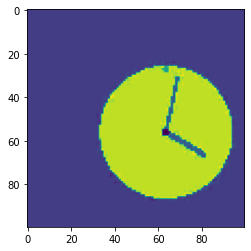

In [ ]:
print("Hour: ", int(y1_train[0]))
print("Minute: ", int(y2_train[0]))    
print("Shape: ", x_train[0].shape)     #this shape show us that image is a black and white image (100,100), but not binarized because your pixels aren't 0 and 1

plt.imshow(x_train[0])

print(x_train[0])



In [ ]:
x_train = x_train.reshape(-1, 100, 100, 1)
x_test = x_test.reshape(-1, 100, 100, 1)
x_validation = x_validation.reshape(-1, 100, 100, 1)

print(x_train.shape, x_test.shape, x_validation.shape)

(35000, 100, 100, 1) (10000, 100, 100, 1) (5000, 100, 100, 1)


# **Neural Network to Hours**

In [ ]:
#Sequential é aconselhado apenas para modelos em simples com uma saída e uma entrada

model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

In [ ]:

model.compile(optimizer = "rmsprop",
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y1_train, epochs=10)

Epoch 1/10
 345/1094 [========>.....................] - ETA: 26s - loss: 0.2801 - accuracy: 0.9159

KeyboardInterrupt: ignored

In [ ]:
def prediction(imgs_data, img_number): 

  predict = model.predict(imgs_data)
  predict = np.argmax(predict[img_number])
  
  img = imgs_data[img_number][:,:,0]
  img = plt.imshow(img)
                   
  return predict, img
   

(6, <matplotlib.image.AxesImage at 0x7fc6e09fb790>)

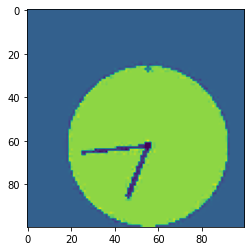

In [ ]:
prediction(x_test, 0)

In [ ]:
#Save and load model

#model.save("/content/drive/MyDrive/Colab Notebooks/Analog_clock/model.h5")
#model = load_model('/content/drive/MyDrive/Colab Notebooks/Analog_clock/model.h5')

# **Neural Network to prediction time**

In [ ]:
    inp = Input(shape=(100, 100, 1))

    x = Conv2D(64, (3,3), activation='relu')(inp)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3,3), activation='relu')(inp)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3,3), activation='relu')(inp)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3,3), activation='relu')(inp)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    hour = Dense(512, activation='relu')(x)
    hour = Dense(12, activation='softmax', name='hour')(hour)

    minute = Dense(512, activation='relu')(x)
    minute = Dense(128, activation='relu')(minute)
    minute = Dense(60, activation='softmax', name='minute')(minute)

    model = Model(inputs=inp, outputs=[hour, minute])


    model.summary()
    

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 98, 98, 128)  1280        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 49, 49, 128)  0          ['conv2d_3[0][0]']               
                                                                                                  
 flatten (Flatten)              (None, 307328)       0           ['max_pooling2d_3[0][0]']    

In [ ]:
model.compile(optimizer = "rmsprop",
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, [y1_train, y2_train], epochs=25)

Epoch 1/25
1094/1094 [==============================] - 312s 283ms/step - loss: 6.8830 - hour_loss: 2.6850 - minute_loss: 4.1980 - hour_accuracy: 0.1098 - minute_accuracy: 0.0189
Epoch 2/25
1094/1094 [==============================] - 310s 283ms/step - loss: 6.2020 - hour_loss: 2.2487 - minute_loss: 3.9533 - hour_accuracy: 0.2107 - minute_accuracy: 0.0421
Epoch 3/25
1094/1094 [==============================] - 310s 283ms/step - loss: 5.5960 - hour_loss: 1.9931 - minute_loss: 3.6029 - hour_accuracy: 0.3038 - minute_accuracy: 0.0905
Epoch 4/25
1094/1094 [==============================] - 310s 283ms/step - loss: 4.9876 - hour_loss: 1.7847 - minute_loss: 3.2029 - hour_accuracy: 0.3875 - minute_accuracy: 0.1621
Epoch 5/25
1094/1094 [==============================] - 309s 283ms/step - loss: 4.3140 - hour_loss: 1.5759 - minute_loss: 2.7381 - hour_accuracy: 0.4653 - minute_accuracy: 0.2752
Epoch 6/25
1094/1094 [==============================] - 309s 283ms/step - loss: 3.6201 - hour_loss: 1.390

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/Analog_clock/model.h5")

In [ ]:
def prediction(imgs_data, img_number): 

  predict = model.predict(imgs_data)
  predict = np.argmax(predict[img_number])
  
  img = imgs_data[img_number][:,:,0]
  img = plt.imshow(img)
                   
  return predict, img